# Diffusion Opinion

In [1]:
import os
import json

import numpy as np

import networkx as nx
#import ndlib
#from ndlib.models.ContinuousModel import ContinuousModel
#import ndlib.models.compartments.NodeNumericalAttribute as na
#from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

import matplotlib.pyplot as plt


In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

In [3]:
# Carica il network completo
full_graph_backbone = nx.read_gexf(os.path.join("..","data_collection","graph","full_network_backbone_opinion.gexf"))

In [3]:
def plot_opinion_distribution(user_opinion, title="Distribuzione delle opinioni degli utenti", save=False, ax=None):
    """Crea un istogramma della distribuzione delle opinioni degli utenti."""
    if ax is None: fig, ax = plt.subplots()   
    
    opinions = list(user_opinion.values())

     # Creazione dell'istogramma
    counts, bins, patches = ax.hist(opinions, bins=20, edgecolor='black', log=True)

    # Colora le barre con una mappa di colori da blu (sinistra) a rosso (destra)
    cmap = plt.get_cmap("coolwarm")  # Blu → Rosso
    norm = plt.Normalize(vmin=0, vmax=1)  # Normalizza tra 0 e 1

    for patch, bin_left in zip(patches, bins[:-1]):
        color = cmap(norm(bin_left))  # Assegna il colore in base alla posizione
        patch.set_facecolor(color)

    ax.set_xlabel("Opinione")# (0 = pro-Biden, 1 = pro-Trump)")
    ax.set_ylabel("Numero di utenti")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    if save: plt.savefig(os.path.join("plots", title))

    if ax is None: plt.show() # Serve per plot multipli

### Diffusione con media pesata 

Il peso corrisponde all'attributo weight dell'arco entrante moltiplicato per la compatibility (1 - differenza di opinioni)

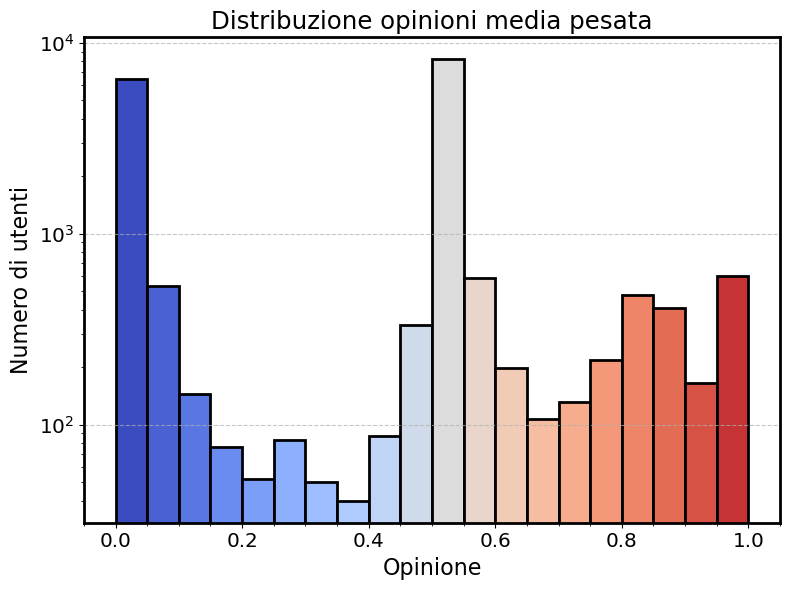

In [42]:
from weighted_opinion_diffusion_mean import WeightedOpinionDiffusionMean

# Inizializza il modello
model = WeightedOpinionDiffusionMean(full_graph_backbone, beta=0.5)

# Esegui iterazioni
proTrump = []
proBiden = []
neutral = []
for t in range(200):
    new_opinions = model.iteration()
    opinions_array = np.asarray(list(new_opinions.values()))
    proTrump.append(opinions_array[opinions_array >= 0.7].size)
    proBiden.append(opinions_array[opinions_array <= 0.3].size)
    neutral.append(opinions_array[np.logical_and(opinions_array > 0.3, opinions_array < 0.7)].size)
    #print(f"Iterazione {t+1}")#

plot_opinion_distribution(new_opinions, title="Distribuzione opinioni media pesata",  save=True)

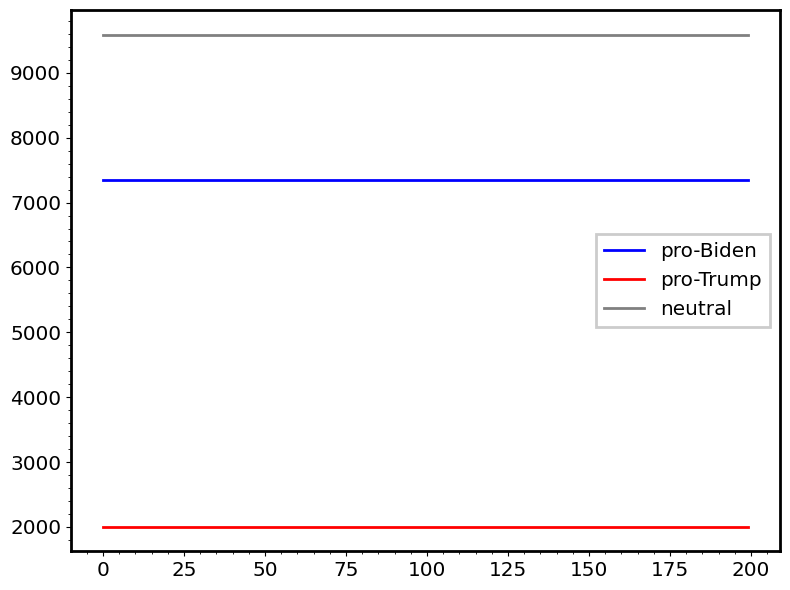

In [43]:
plt.plot(range(200), proBiden, color='b', label='pro-Biden')
plt.plot(range(200), proTrump, color='r', label='pro-Trump')
plt.plot(range(200), neutral, color='grey', label='neutral')
plt.legend()
plt.show()

## Distribuzione opinone con un solo nodo

Invece di fare la media pesata viene estratto randomicamente un nodo casuale tra i vicini entranti

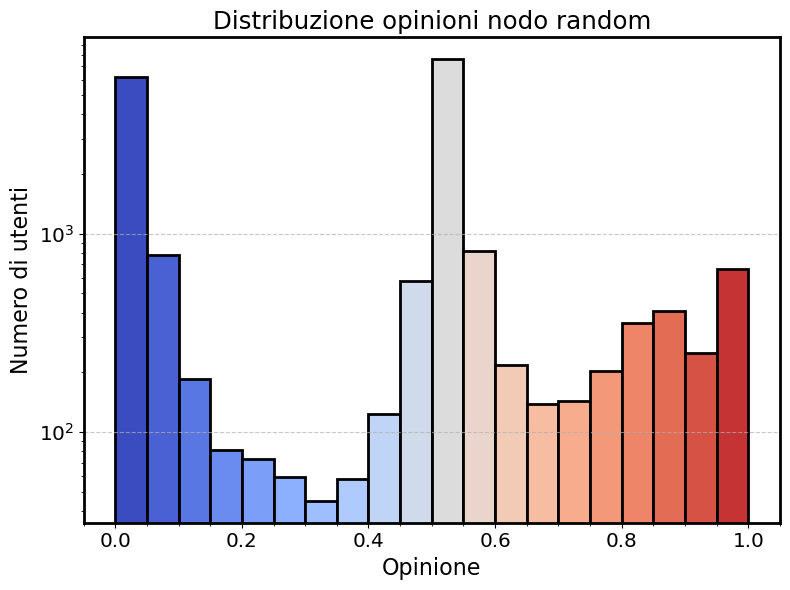

In [12]:
from weighted_opinion_diffusion import WeightedOpinionDiffusion

# Creo una copia del network per poi normalizzare i pesi degli edges (senza modificare quella originale)
full_graph_backbone_normweight = full_graph_backbone

model = WeightedOpinionDiffusion(full_graph_backbone_normweight, beta=0.5)
model.normalize_weights()

# Esegui iterazioni
proTrump = []
proBiden = []
neutral = []
for t in range(200):
    new_opinions = model.iteration()
    opinions_array = np.asarray(list(new_opinions.values()))
    proTrump.append(opinions_array[opinions_array >= 0.7].size)
    proBiden.append(opinions_array[opinions_array <= 0.3].size)
    neutral.append(opinions_array[np.logical_and(opinions_array > 0.3, opinions_array < 0.7)].size)
    #print(f"Iterazione {t+1}")#

plot_opinion_distribution(new_opinions, title="Distribuzione opinioni nodo random",  save=True)

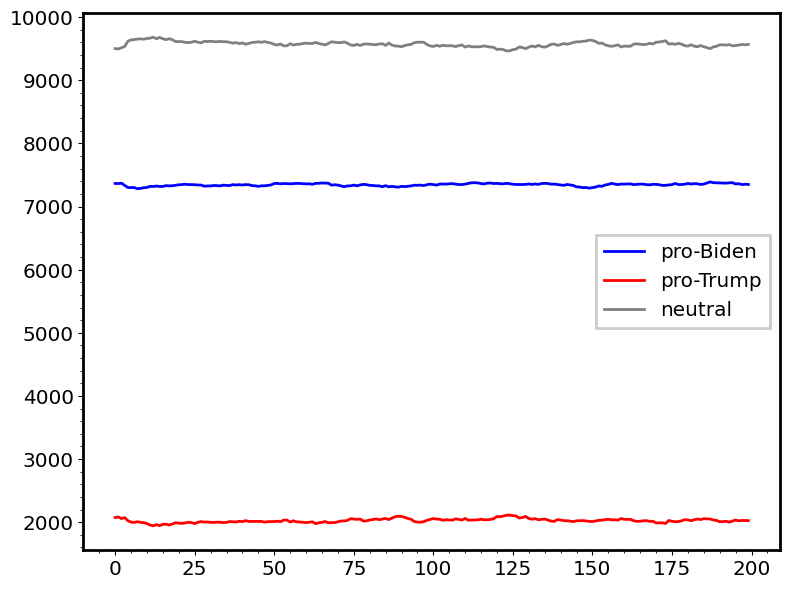

In [13]:
plt.plot(range(200), proBiden, color='b', label='pro-Biden')
plt.plot(range(200), proTrump, color='r', label='pro-Trump')
plt.plot(range(200), neutral, color='grey', label='neutral')
plt.legend()
plt.show()

## Implementazione con NDlib [DA FARE]

In [22]:
# Estrae il grafico Undirected e Unweighted
real_graph = full_graph_backbone.to_undirected()

In [25]:
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op

g = full_graph_backbone

model = op.AlgorithmicBiasModel(g)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.5)
config.add_model_parameter("gamma", 0)  # No bias = Deffuant

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(100)


from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
viz = OpinionEvolution(model, iterations)
viz.plot()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices